<div style="width:100%;text-align: center;">
    <img src="https://user.oc-static.com/upload/2019/02/24/15510245026714_Seattle_logo_landscape_blue-black.png" />
</div>

# DEUXIEME PARTIE: MODELING AND COMPARING ALGORITHMS
##### Providence MBAINDIGUIM, ITS4 Finance

In [88]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.


### Import des bibliothèques utilisées

In [62]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit, GridSearchCV
from sklearn.linear_model import LinearRegression, Lasso, Ridge, SGDRegressor, ElasticNet
from sklearn.svm import SVR
from sklearn.preprocessing import *
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.metrics import *
from sklearn.ensemble import RandomForestRegressor
from yellowbrick.model_selection import LearningCurve
from yellowbrick.datasets import load_concrete
from yellowbrick.regressor import ResidualsPlot
from yellowbrick.regressor import PredictionError
from yellowbrick.regressor import CooksDistance
from yellowbrick.model_selection import ValidationCurve

from xgboost import XGBRegressor

#### On importe la base

In [287]:
### EnergyStarSCore et HarvesineDistance contiennent de données manquantes. Il faut les supprimer sinon ils perturberont les estimations
clean_data = pd.read_csv("Clean_Data.csv")
cl_data= clean_data.drop(['ENERGYSTARScore'], axis=1)
cl_data= cl_data.drop(['harvesine_distance'], axis=1)
cl_data['SteamUse(kWh)']=cl_data['SteamUse(kBtu)']/3.4112

In [132]:
cl_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3365 entries, 0 to 3364
Data columns (total 29 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   OSEBuildingID                  3365 non-null   int64  
 1   DataYear                       3365 non-null   int64  
 2   BuildingType                   3365 non-null   object 
 3   TaxParcelIdentificationNumber  3365 non-null   object 
 4   Latitude                       3365 non-null   float64
 5   Longitude                      3365 non-null   float64
 6   Neighborhood                   3365 non-null   object 
 7   YearBuilt                      3365 non-null   int64  
 8   NumberofFloors                 3365 non-null   int64  
 9   PropertyGFATotal               3365 non-null   float64
 10  PropertyGFABuilding(s)         3365 non-null   int64  
 11  PropertyGFAParking             3365 non-null   int64  
 12  SiteEUI(kBtu/sf)               3365 non-null   f

In [288]:
### Nous allons supprimer certaines variables pour ne retenir que celles pertinentes
col=(['DataYear','ComplianceIssue','ComplianceStatus','LargestPropertyUseType','Neighborhood','BuildingType','Steam(kWh)','SteamUse(kBtu)','SiteEUI(kBtu/sf)','EPAPropertyType', 'NaturalGas(kBtu)','SiteEnergyUse(kWh)','Latitude', 'Longitude','YearBuilt','TaxParcelIdentificationNumber','GFAPerFloor','BuildingAge','PropertyGFAParking','NumberofFloors','OSEBuildingID'])
cl_data.drop(col, axis=1, inplace=True)

In [289]:
cl_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3365 entries, 0 to 3364
Data columns (total 8 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   PropertyGFATotal           3365 non-null   float64
 1   PropertyGFABuilding(s)     3365 non-null   int64  
 2   LargestPropertyUseTypeGFA  3365 non-null   float64
 3   Electricity(kWh)           3365 non-null   float64
 4   GHGEmissionsIntensity      3365 non-null   float64
 5   NaturalGas(kWh)            3365 non-null   float64
 6   SourceEUI(kWh/sf)          3365 non-null   float64
 7   SteamUse(kWh)              3365 non-null   float64
dtypes: float64(7), int64(1)
memory usage: 210.4 KB


### on remet à jour la liste des colonnes catégorielles

In [291]:
objectColumns = list(cl_data.dtypes[cl_data.dtypes == np.object].index)
numericColumns = list(cl_data.dtypes[cl_data.dtypes != np.object].index)
print(objectColumns)
print(numericColumns)

[]
['PropertyGFATotal', 'PropertyGFABuilding(s)', 'LargestPropertyUseTypeGFA', 'Electricity(kWh)', 'GHGEmissionsIntensity', 'NaturalGas(kWh)', 'SourceEUI(kWh/sf)', 'SteamUse(kWh)']


#### Separation des features en celles à predire et celles explicatives

In [292]:
y_columns = ['GHGEmissionsIntensity', 'SourceEUI(kWh/sf)']
X = cl_data.drop(y_columns, axis=1)
y = cl_data[y_columns]

print(X.shape)

print(y.shape)
print(len(numericColumns))
for i in y_columns:
   numericColumns.remove(i)
print(len(numericColumns))




(3365, 6)
(3365, 2)
8
6


In [199]:
y.info()
#print(y.columns)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3365 entries, 0 to 3364
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   GHGEmissionsIntensity  3365 non-null   float64
 1   SourceEUI(kWh/sf)      3365 non-null   float64
dtypes: float64(2)
memory usage: 52.7 KB


## Spliter les données

In [293]:
preprocessor = make_column_transformer((RobustScaler(),numericColumns),(OneHotEncoder(handle_unknown = 'ignore'),objectColumns))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=45)

### Estimation d'un modèle par regression linéaire

In [258]:
model = make_pipeline(preprocessor,LinearRegression())
model.fit(X_train,y_train)
print("score d'entrainement = ",model.score(X_train,y_train))
y_pred = model.predict(X_test)
print("score de la prédiction:",model.score(X_test, y_test)) 
print("MAE = ",mean_absolute_error(y_test,y_pred))
print("RMSE = ",np.sqrt(mean_squared_error(y_test,y_pred)))
print("median abs err = ",median_absolute_error(y_test,y_pred))

score d'entrainement =  0.5791740380469815
score de la prédiction: 0.5781730785839981
MAE =  6.3939445867194875
RMSE =  10.784724623321186
median abs err =  5.494250442844262


### Le score de prédiction est assez correct, peut-il être meilleur en utilisant un modèle par variable à prédire:

In [259]:
for column in y_columns:
    X_train, X_test, y_train, y_test = train_test_split(X, y[column], test_size=0.2, random_state=45)
    model = make_pipeline(preprocessor,LinearRegression())
    model.fit(X_train,y_train)
    y_pred = model.predict(X_test)
    print('Méthode: LinearRegression OneHotEncoder RobustScaler')
    print('+ utilisation de pipelines')
    print('Prédiction de ',column)
    print('score d\'entrainement = ',model.score(X_train,y_train))
    print("score de la prédiction: ",  model.score(X_test, y_test)), 
    print("MAE = ",mean_absolute_error(y_test,y_pred))
    print("RMSE = ",np.sqrt(mean_squared_error(y_test,y_pred)))
    print("median abs err = ",median_absolute_error(y_test,y_pred))
    print('')

Méthode: LinearRegression OneHotEncoder RobustScaler
+ utilisation de pipelines
Prédiction de  GHGEmissionsIntensity
score d'entrainement =  0.577009006605744
score de la prédiction:  0.5838726835569074
MAE =  0.5927271204829379
RMSE =  0.8156541012248301
median abs err =  0.46437781396070466

Méthode: LinearRegression OneHotEncoder RobustScaler
+ utilisation de pipelines
Prédiction de  SourceEUI(kWh/sf)
score d'entrainement =  0.5813390694882192
score de la prédiction:  0.5724734736110895
MAE =  12.195162052956034
RMSE =  15.23007809529864
median abs err =  10.524123071727823



#### Des scores moins concluants avec ces améliorations

In [260]:
y = cl_data[y_columns]
X = cl_data.drop(y_columns, axis=1)

# essais peu concluant avec les transformation appliquées avant.
encoder=LabelEncoder()
for column in objectColumns:
    X[column] = encoder.fit_transform(X[column])
    
encoder=StandardScaler()
X_std = encoder.fit_transform(X)

for column in y_columns:
    X_train, X_test, y_train, y_test = train_test_split(X_std, y[column], test_size=0.2, random_state=45)
    model = LinearRegression()
    model.fit(X_train,y_train)
    y_pred = model.predict(X_test)
    print('Méthode: LinearRegression LabelEncoder StandardScaler')
    print('Prédiction de ',column)
    print('score d\'entrainement = ',model.score(X_train,y_train))
    print("score de la prédiction:"), 
    print("MAE = ",mean_absolute_error(y_test,y_pred))
    print("RMSE = ",np.sqrt(mean_squared_error(y_test,y_pred)))
    print("median abs err = ",median_absolute_error(y_test,y_pred))
    print('')

Méthode: LinearRegression LabelEncoder StandardScaler
Prédiction de  GHGEmissionsIntensity
score d'entrainement =  0.577009006605744
score de la prédiction:
MAE =  0.5927271204830309
RMSE =  0.8156541012244352
median abs err =  0.46437781396218214

Méthode: LinearRegression LabelEncoder StandardScaler
Prédiction de  SourceEUI(kWh/sf)
score d'entrainement =  0.5813390694882192
score de la prédiction:
MAE =  12.195162052779104
RMSE =  15.230078095066062
median abs err =  10.524123071643315



### Une nette amélioration par rapport au modèle précedemment

In [261]:
encoder= LabelBinarizer()
for column in objectColumns:
    X[column] = encoder.fit_transform(X[column])
    
encoder=StandardScaler()
X_std = encoder.fit_transform(X)

for column in y_columns:
    X_train, X_test, y_train, y_test = train_test_split(X_std, y[column], test_size=0.2, random_state=45)
    model = LinearRegression()
    model.fit(X_train,y_train)
    y_pred = model.predict(X_test)
    print('Méthode: LinearRegression LabelBinarizer StandardScaler')
    print('Prédiction de ',column)
    print('score d\'entrainement = ',model.score(X_train,y_train))
    print("score de la prédiction:"), 
    print("MAE = ",mean_absolute_error(y_test,y_pred))
    print("RMSE = ",np.sqrt(mean_squared_error(y_test,y_pred)))
    print("median abs err = ",median_absolute_error(y_test,y_pred))
    print('')

Méthode: LinearRegression LabelBinarizer StandardScaler
Prédiction de  GHGEmissionsIntensity
score d'entrainement =  0.577009006605744
score de la prédiction:
MAE =  0.5927271204830309
RMSE =  0.8156541012244352
median abs err =  0.46437781396218214

Méthode: LinearRegression LabelBinarizer StandardScaler
Prédiction de  SourceEUI(kWh/sf)
score d'entrainement =  0.5813390694882192
score de la prédiction:
MAE =  12.195162052779104
RMSE =  15.230078095066062
median abs err =  10.524123071643315



**Conclusion**

Le choix des transformers utilisés pour standardiser nos données est très impactant sur nos résultat. Un LabelEncoder ou un  LabelBinarizer associés avec des StandardScaler donne des résultats très médiocres. Un pipeline utilisant RobustScaler et OneHotEncoder donne des résultats bien meilleur et totalement admissible mais obligent par contre à ignorer certaines lignes dont les catégories se retrouvent dans le jeu d'entrainement mais pas dans le jeu de test et ne sont par conséquent pas connues du modèle. On essaiera de gommer ces imperfections dans la suite avec une validation croisée.

essai raté avec le StratifiedShuffleSplit...

## <a id="model-compare">Estimations et Comparaison des modèles<a/> 

In [262]:
results = []
algos = {
    'LinearRegression' : LinearRegression(),
    'Ridge' : Ridge(),
    'Lasso' : Lasso(tol=0.2),
    'ElasticNet' : ElasticNet(),
    'SGDRegressor': SGDRegressor(),
    'SVR': SVR(),
    'RandomForestRegressor' : RandomForestRegressor(),
    'XGBRegressor' : XGBRegressor()
}
X_train, X_test, y_train_all, y_test_all = train_test_split(X, y, test_size=0.2, random_state=45)

In [263]:
for algo_name, algo in algos.items():
    print('Algorithme: ',algo_name)
    for column in y_columns:
        y_test = y_test_all[column]
        y_train = y_train_all[column]
        model = make_pipeline(preprocessor,algo)
        model.fit(X_train,y_train)
        y_pred = model.predict(X_test)
        print('Prédiction de ',column)
        print('score d\'entrainement = ',model.score(X_train,y_train))
        print("score de la prédiction: ",  model.score(X_test, y_test))
        mae = mean_absolute_error(y_test,y_pred)
        rmse = np.sqrt(mean_squared_error(y_test,y_pred))
        med_abs_err = median_absolute_error(y_test,y_pred)
        print("MAE = ", mae)        
        print("RMSE = ",rmse)
        print("median abs err = ", med_abs_err)
        print('')
        results.append([algo_name, column, model.score(X_test, y_test), mae, rmse, med_abs_err])
    print('-'*100)

Algorithme:  LinearRegression
Prédiction de  GHGEmissionsIntensity
score d'entrainement =  0.577009006605744
score de la prédiction:  0.5838726835569074
MAE =  0.5927271204829379
RMSE =  0.8156541012248301
median abs err =  0.46437781396070466

Prédiction de  SourceEUI(kWh/sf)
score d'entrainement =  0.5813390694882192
score de la prédiction:  0.5724734736110895
MAE =  12.195162052956034
RMSE =  15.23007809529864
median abs err =  10.524123071727823

----------------------------------------------------------------------------------------------------
Algorithme:  Ridge
Prédiction de  GHGEmissionsIntensity
score d'entrainement =  0.5770084313254795
score de la prédiction:  0.5838361877058749
MAE =  0.5928344490042144
RMSE =  0.8156898683287127
median abs err =  0.4640870206143184

Prédiction de  SourceEUI(kWh/sf)
score d'entrainement =  0.5813374140621854
score de la prédiction:  0.5722801949632463
MAE =  12.198908568464145
RMSE =  15.233520356888143
median abs err =  10.542977854688578


In [264]:
df_results = pd.DataFrame(results,columns=['algorithm', 'column','predict score', 'MAE', 'RMSE', 'median abs err'])
display(df_results.sort_values(by=['column','predict score'],ascending=False))


,algorithm,column,predict score,MAE,RMSE,median abs err
15,XGBRegressor,SourceEUI(kWh/sf),9.182334e-01,3.919511e+00,6.660527e+00,2.102634e+00
13,RandomForestRegressor,SourceEUI(kWh/sf),9.117603e-01,3.990695e+00,6.919149e+00,1.882144e+00
1,LinearRegression,SourceEUI(kWh/sf),5.724735e-01,1.219516e+01,1.523008e+01,1.052412e+01
3,Ridge,SourceEUI(kWh/sf),5.722802e-01,1.219891e+01,1.523352e+01,1.054298e+01
5,Lasso,SourceEUI(kWh/sf),5.090282e-01,1.333267e+01,1.632108e+01,1.188015e+01
7,ElasticNet,SourceEUI(kWh/sf),3.159431e-01,1.599574e+01,1.926490e+01,1.479486e+01
11,SVR,SourceEUI(kWh/sf),-2.090278e-02,1.822447e+01,2.353492e+01,1.439039e+01
9,SGDRegressor,SourceEUI(kWh/sf),-8.500329e+42,1.013121e+22,6.791074e+22,3.344999e+10
14,XGBRegressor,GHGEmissionsIntensity,9.534080e-01,1.302443e-01,2.729284e-01,5.572879e-02
12,RandomForestRegressor,GHGEmissionsIntensity,9.460754e-01,1.310447e-01,2.936205e-01,5.200000e-02


Le XGBRegresson et le RandomForestRegressor sont nos deux algorithmes les plus performants. 
Ils obtiennent des résultats très satisfaisants. 
Cependant une optimisation des paramètres des différents algorithmes pourrait créer des différences. 
On va donc chercher à optimiser les paramètres de ces différents algorithme par le biais d'une validation croisée.
Nous supprimerons néanmoins le SGDRegressor qui est totalement contre-performant et le SVR qui a des résultats pas assez bon.

### VALIDATION DES MODELES POUR RETENIR LE MEILLEUR

**RandomForest:**
Now we will try to improve the setting of the Max_depth and max_features parameters.

we will use the average of the cross validation scores of the training dataset with 5 splits

In [324]:
### On veut seulement prédire les emissions de CO2

X = cl_data.drop(['GHGEmissionsIntensity'],axis=1) 
y = cl_data['GHGEmissionsIntensity']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=45)

Au regard des comparaisons efféctuées précedemment, les meilleurs modèles sont XGBoost(1er) et RandomForest(2eme).           
Cependant, avec les tests de validation effectués sur ces modèles ci -dessous, le XGBoost a tendance à surapprendre (Training score=1)et bien d'autres difficultés donc j'ai choisi le RandomForest comme le meilleur (nommé best_model). Lui aussi surapprend mais d'une moindre proportion et montre qu'avec l'augmentation des données, il apprendra normalement

## Performing k-fold cross-validation for hyperparameter tuning, environ 5 minutes d'execution

In [392]:
rf = RandomForestRegressor(n_estimators=100, criterion="mse",
                           bootstrap=True, oob_score=True, n_jobs=2,
                           random_state=42)

#Defining 3-dimensional hyperparameter space as a Python dictionary
hyperparameter_space = {'max_depth':[None,4,6,8,10,12,15,20], 
                        'min_samples_leaf':[1,2,4,6,8,10,20,30],
                        'max_features':['auto','sqrt','log2']}

from sklearn.model_selection import GridSearchCV
gs =GridSearchCV(rf, param_grid=hyperparameter_space , 
                  scoring="neg_mean_squared_error",
                  n_jobs=2, cv=5, return_train_score=True)

gs.fit(X_train, y_train)
print("Optimal hyperparameter combination: ", gs.best_params_)
print("Mean cross-validated MSE or training score of the best_estimator: ",
       np.sqrt(-gs.best_score_))
gs.best_estimator_.fit(X_train, y_train)
y_pred = gs.best_estimator_.predict(X_test)

from sklearn.metrics import mean_squared_error as MSE
rmse_test = np.sqrt(MSE(y_test, y_pred))
print("Test score: ", np.round(rmse_test, 2))

Optimal hyperparameter combination:  {'max_depth': 15, 'max_features': 'auto', 'min_samples_leaf': 1}
Mean cross-validated MSE or training score of the best_estimator:  7.864265251930866
Test score:  6.56


## Méthode manuelle pour obtenir les max_depth, hyperparameter

In [325]:
def test_model_mean(modl,train,y):
        cv = KFold(n_splits=5, shuffle=True, random_state=42)
        r2 = make_scorer(r2_score)
        r2_val_score = cross_val_score(modl, train, y, cv=cv, scoring=r2)
        scores = r2_val_score.mean()
        return scores
    
#Maximum depth    
params=[2,3,5,10,15,20,25,30]
score_train=[]
for p in params:
    model=RandomForestRegressor()
    model.set_params(max_depth=p)
    score=test_model_mean(model,X_train,y_train)
    score_train.append(score)

Text(0, 0.5, 'Mean of the CV score')

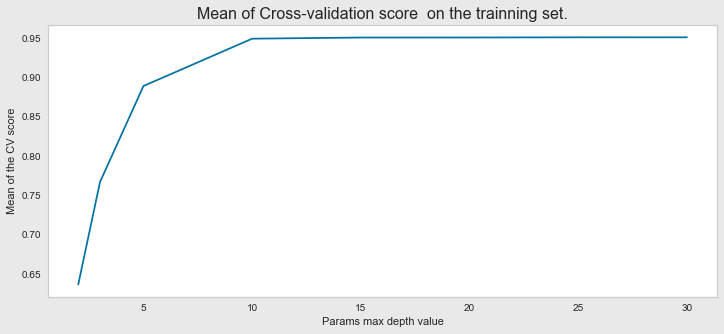

In [326]:
#Visualisation
fig=plt.figure(figsize=[12,5])
fig.patch.set_facecolor('#E0E0E0')
fig.patch.set_alpha(0.7)
plt.title("Mean of Cross-validation score  on the trainning set.",size=16)
plt.plot(params,score_train)
plt.grid()
plt.xlabel("Params max depth value")
plt.ylabel("Mean of the CV score")

**max_depth=15**

### Let's check the results of the optimized RandomForest regressor model

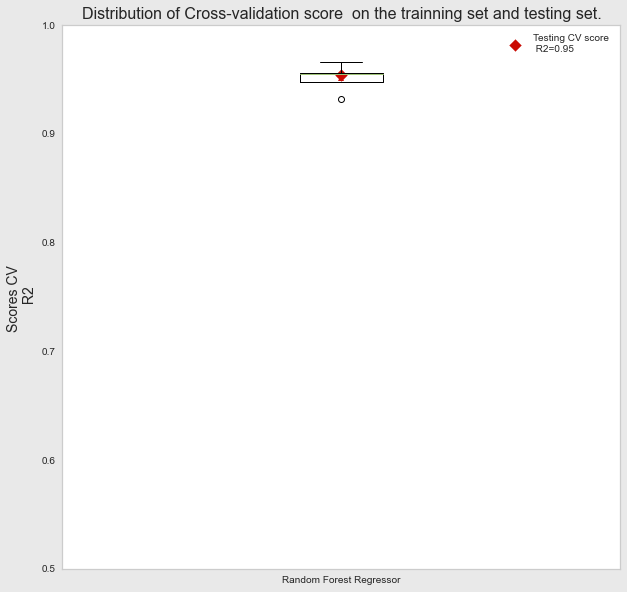

In [321]:
best_model=RandomForestRegressor(n_estimators=100, max_depth=15)

def test_model(modl,train,y):
        cv = KFold(n_splits=5, shuffle=True, random_state=42)
        r2 = make_scorer(r2_score)
        r2_val_score = cross_val_score(modl, train, y, cv=cv, scoring=r2)
        scores = r2_val_score
        return scores
the_scores=test_model(best_model,X_train,y_train)
best_model.fit(X_train,y_train)
y_pred=best_model.predict(X_test)
validation_score=r2_score(y_test,y_pred)

#### Plotting 
fig=plt.figure(figsize=[10,10])
fig.patch.set_facecolor('#E0E0E0')
fig.patch.set_alpha(0.7)
plt.title("Distribution of Cross-validation score  on the trainning set and testing set.",size=16)
plt.boxplot(the_scores,showmeans=True)
plt.scatter(x=[1],y=[validation_score],s=70,c="r",marker="D",label="Testing CV score \n R2={}".format(round(validation_score,2)))
plt.ylabel("Scores CV \n R2",size=14)
plt.xticks([1],["Random Forest Regressor"])
plt.ylim(0.5,1)
plt.xlim(0.5,1.5)
plt.grid()
plt.legend()

### Le R² du Cross Validation est de 95%

#  The features that impact the prediction the most  

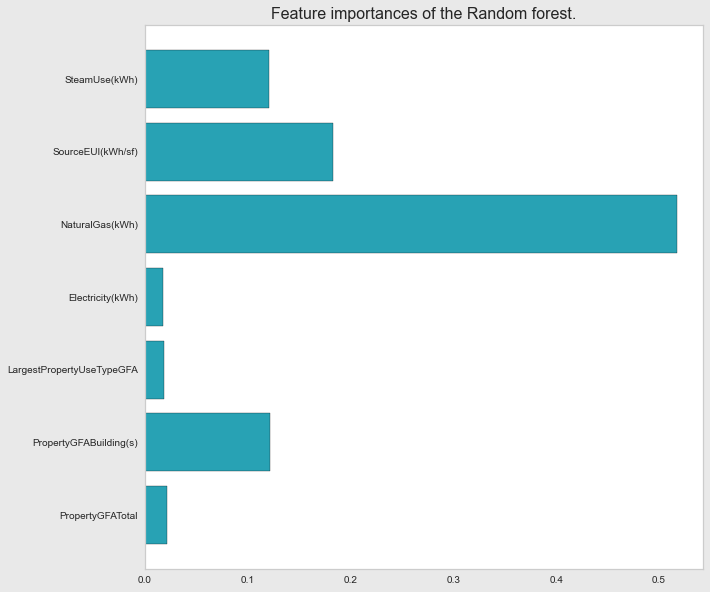

In [322]:
fig=plt.figure(figsize=[10,10])
fig.patch.set_facecolor('#E0E0E0')
fig.patch.set_alpha(0.7)
plt.title("Feature importances of the Random forest.",size=16)
plt.barh(X.columns, best_model.feature_importances_,color="#28a2b4",edgecolor='black')
plt.grid()

The   prediction result depends mainly on the Electricity,  The Gross Floor Area of building, GFA or largest property.

In [319]:
y_pred

array([[ 4.30757801, 88.91779015],
       [ 2.00156067, 36.86254396],
       [ 2.51145468, 47.66119578],
       ...,
       [ 3.25087964, 66.87133646],
       [ 1.216375  , 18.9293303 ],
       [ 0.713     , 29.95779601]])

### Predictions des emissions de CO2 de quelques batiments et estimations des erreurs

In [323]:
df_res=pd.DataFrame({"True values": y_test,"Predictions":y_pred})
df_res["Error"]=abs(df_res["True values"]-df_res["Predictions"])/df_res["True values"]*100
df_res.head()
def color_to_use(num):
    if np.isinf(num):
        return "#cc2900"
    elif num> 80:
        return "#cc2900"
    elif num >50:
        return "#dfa61f"
    elif num>30:
        return "#dddf1f"
    elif num>10:
        return "#7cce2e"
    else:
        return "#13a90d"
df_res["color to use"]=df_res["Error"].apply(color_to_use)
df_res.head()

,True values,Predictions,Error,color to use
1432,4.307578,4.307578,1.443328e-13,#13a90d
3191,2.300000,2.251500,2.108696e+00,#13a90d
1903,2.300000,2.288811,4.864925e-01,#13a90d
1651,0.700000,0.664658,5.048927e+00,#13a90d
1069,0.400000,0.365325,8.668807e+00,#13a90d


### Courbe des erreurs de prédictions

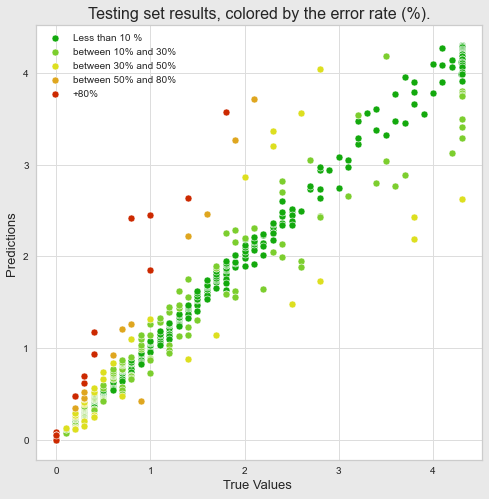

In [327]:
df_res=df_res.sort_values(by = "Error")
dict_lab={"#cc2900":'+80%','#dfa61f':"between 50% and 80%"
          ,'#dddf1f':"between 30% and 50%"
          ,'#7cce2e':"between 10% and 30%"
          ,'#13a90d':"Less than 10 %"}
fig=plt.figure(figsize=[8,8])
fig.patch.set_facecolor('#E0E0E0')
fig.patch.set_alpha(0.7)
plt.title("Testing set results, colored by the error rate (%).",size=16)
for c in df_res["color to use"].unique():
    d=df_res.loc[df_res["color to use"]==c]
    sns.scatterplot(data=d,x="True values",y="Predictions",color=c,label=dict_lab[c])

plt.xlabel('True Values ',size=13)
plt.ylabel('Predictions ',size=13)
plt.grid(color='#dddddd')

#### Distribution des taux d'erreurs sur les valeurs réelles

Text(0.5, 0, 'CO2 emissions')

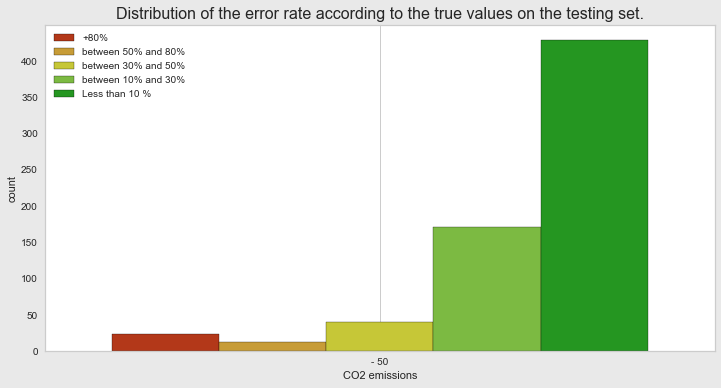

In [328]:
def regroup(num):
    if num<50:
        return "- 50"
    elif num<150:
        return "50-150"
    elif num<250:
        return "150-250"
    else:
        return "+250"
df_res["regroup"]=df_res["True values"].apply(regroup)
df_res=df_res.sort_values(by = "True values")

fig=plt.figure(figsize=[12,6])
fig.patch.set_facecolor('#E0E0E0')
fig.patch.set_alpha(0.7)
plt.title("Distribution of the error rate according to the true values on the testing set.",size=16)
sns.countplot(data=df_res,x="regroup",hue="color to use",hue_order=dict_lab.keys(),palette=['#cc2900', '#dfa61f', '#dddf1f', '#7cce2e', '#13a90d'], edgecolor="black")
plt.legend(dict_lab.values())
plt.grid()
plt.xlabel("CO2 emissions")

0.919158823701856


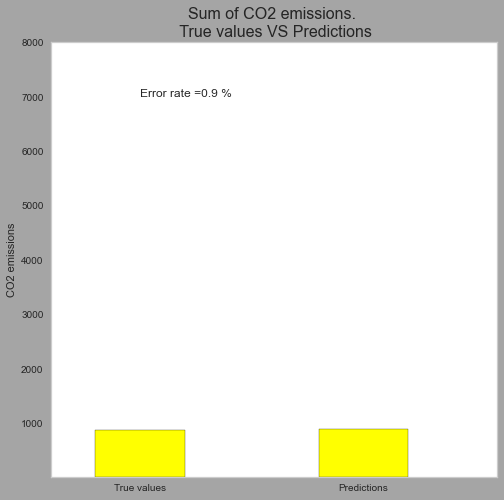

In [367]:
t,p=df_res["True values"].sum(),df_res["Predictions"].sum()
error=abs(t-p)/t*100
print(error)

fig=plt.figure(figsize=[8,8])
fig.patch.set_facecolor('gray')
fig.patch.set_alpha(0.7)
plt.title("Sum of CO2 emissions. \n True values VS Predictions",size=16)
plt.bar(x=[1,2],height=[df_res["True values"].sum(),df_res["Predictions"].sum()],color="yellow",width=0.4, edgecolor="black")
plt.xticks([1,2],["True values","Predictions"])
plt.text(1,7000,"Error rate ={} %".format(round(error,1)),size=12)
plt.ylabel("CO2 emissions")
plt.ylim(10,8000)
plt.xlim(0.6,2.6)
plt.grid()

Avec un taux d'erreur de 0.9%, le modèle est éfficient sous reserve de validation

### On va diagnostiquer les courbes de cross-validation et du learning curve

In [141]:
pip install yellowbrick

Note: you may need to restart the kernel to use updated packages.


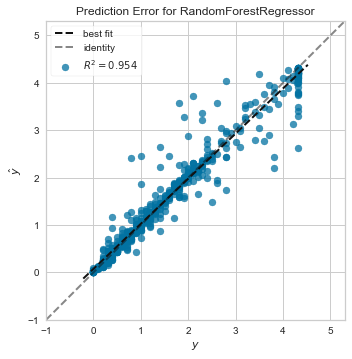

<AxesSubplot:title={'center':'Prediction Error for RandomForestRegressor'}, xlabel='$y$', ylabel='$\\hat{y}$'>

In [333]:

visualizer = PredictionError(best_model)

visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
visualizer.show()  

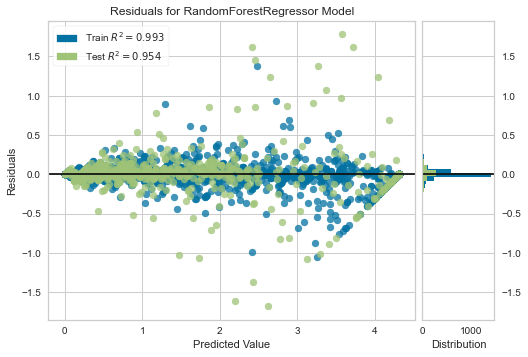

<AxesSubplot:title={'center':'Residuals for RandomForestRegressor Model'}, xlabel='Predicted Value', ylabel='Residuals'>

In [334]:
visualizer = ResidualsPlot(best_model)

visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
visualizer.show()                 # Finalize and render the figure

### Courbe de validation

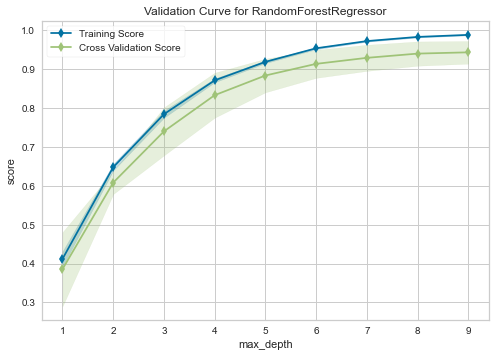

<AxesSubplot:title={'center':'Validation Curve for RandomForestRegressor'}, xlabel='max_depth', ylabel='score'>

In [335]:
viz = ValidationCurve( RandomForestRegressor(), param_name="max_depth",
    param_range=np.arange(1, 10), cv=5, scoring="r2", random_state=42)

# Fit and show the visualizer
viz.fit(X, y)
viz.show()

### Courbe d'appentissage

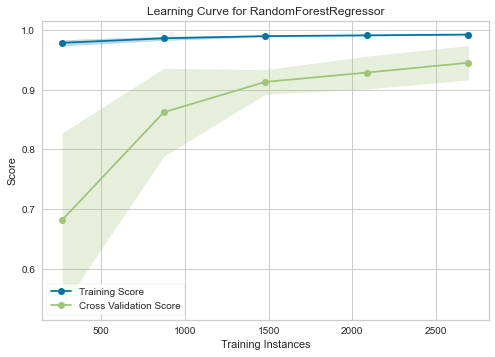

<AxesSubplot:title={'center':'Learning Curve for RandomForestRegressor'}, xlabel='Training Instances', ylabel='Score'>

In [336]:
visualizer = LearningCurve(best_model, scoring='r2', random_state=42)

visualizer.fit(X, y)        # Fit the data to the visualizer
visualizer.show() 

#### Le modèle surapprend cependant, ces deux courbes vont certainement se croiser quelques si nous augmentons la taille de nos données (training instances)

### Nombre de features à utiliser

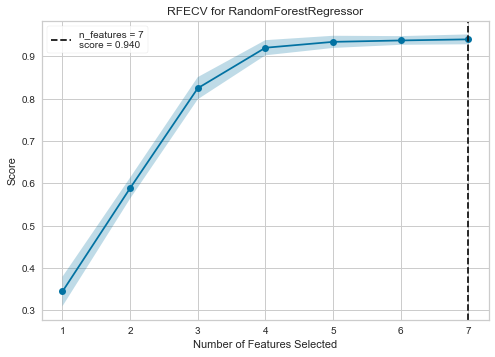

<AxesSubplot:title={'center':'RFECV for RandomForestRegressor'}, xlabel='Number of Features Selected', ylabel='Score'>

In [337]:
from sklearn.model_selection import StratifiedKFold

from yellowbrick.model_selection import RFECV

cv = StratifiedKFold(5)
visualizer = RFECV(RandomForestRegressor(), cv=5)

visualizer.fit(X_train, y_train)        # Fit the data to the visualizer
visualizer.show() 